In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import gensim.models.word2vec as w2v
import multiprocessing
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datetime

In [2]:
df = pd.read_csv('../ethan/washington_outages.csv')

In [62]:
df

,Area Affected,index,Year,Month,Event Date and Time,Restoration Date and Time,Duration,Utility/Power Pool,NERC Region,Type of Disturbance,Loss (megawatts),Number of Customers Affected
0,King,2,2012,1.0,2012-01-19 07:00:00,2012-01-20 15:00:00,"32 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Winter Storm,1600,426000
1,Pierce,2,2012,1.0,2012-01-19 07:00:00,2012-01-20 15:00:00,"32 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Winter Storm,1600,426000
2,Thurston,2,2012,1.0,2012-01-19 07:00:00,2012-01-20 15:00:00,"32 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Winter Storm,1600,426000
3,WA,22,2013,5.0,2013-05-09 13:21:00,2013-05-09 16:21:00,"3 Hours, 0 Minutes",WECC,WECC,Electrical System Separation (Islanding),Unknown,Unknown
4,King,72,2013,11.0,2013-11-02 00:00:00,2013-11-04 06:00:00,"54 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Heavy Winds,Unknown,105000
...,...,...,...,...,...,...,...,...,...,...,...,...
68,Skagit,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000
69,Snohomish,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000
70,King,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000
71,Kitsap,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000


In [4]:
df.dtypes

Area Affected                    object
index                             int64
Year                              int64
Month                           float64
Event Date and Time              object
Restoration Date and Time        object
Duration                         object
Utility/Power Pool               object
NERC Region                      object
Type of Disturbance              object
Loss (megawatts)                 object
Number of Customers Affected     object
dtype: object

In [73]:
df[df['Number of Customers Affected']!='Unknown']['index'].unique()

array([  2,  72, 124, 126, 134,  23,  43,  61,  69,  70,  71,  79,  80,
        81,  88,  10,  54,  74,  75,  84,  85,  64, 123, 125], dtype=int64)

In [6]:
df_tweet = pd.read_csv('../ethan/washington_outage_tweets.csv')

In [7]:
df_tweet_outage = df_tweet[df_tweet['outage'] == 1]

In [8]:
df_tweet_outage['timestamp'] = pd.to_datetime(df_tweet_outage['timestamp'])

C:\Users\YOU-Family\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_tweet.dtypes

event_row_or_county    object
timestamp              object
text                   object
outage                  int64
dtype: object

In [10]:
df_2018 = df[df['Year']==2018][['index','Month']]
df_2018.drop_duplicates(subset = 'index', inplace = True)


In [11]:
df_2018

,index,Month
57,64,6.0
58,78,7.0
59,123,12.0
67,124,12.0
68,125,12.0


In [12]:
dummies_2018 = pd.get_dummies(data = df_2018, columns = ['Month'], prefix = "")
df_2018 = dummies_2018.drop(['index'], axis = 1)


In [12]:
df_2018 = df_2018.sum()

In [13]:
#a new function to automate the conversion of top words in a series into dataframe with Month & count

def top_words(word_series):
    #convert the series into a dataframe with the sum values under column name count
    word_series = word_series.to_frame(name='count')

    #assign the index (in our case the words) into a a new column named 'word'
    word_series['Month'] = word_series.index

    #create new numeric indices in-place of where the orignal 'Month' index column was
    word_series.reset_index(drop=True, inplace=True)

    #sort values by count in descending order and reassign them into the dataframe
    word_series.sort_values(by='count',ascending=False, inplace=True)
    
    #swap the columns to have the Month column as the first column after the index
    word_series = word_series[['Month','count']]

    return word_series

In [14]:
df_2018 = top_words(df_2018)


In [15]:
df_2018

,Month,count
2,_12.0,3
0,_6.0,1
1,_7.0,1


In [ ]:
#example from https://github.com/iceberg425/Client_Project/blob/master/02.2_Data_Cleaning_Weather_and_Outage.ipynb
# years = ['2012', '2013', '2014', '2015', '2016', '2017']

# # Creating 6 dataframes corresponding to 6 different years (2012 - 2017) consisting of only confirmed outages.
# df_years = []
# for year in years:
#     df_years['Year'] = df['Year']
#     df_years['Month'] = df['Month']

In [ ]:
df_years

In [ ]:


# label = ['Oct', 'Nov', 'Dec']
# months = ['Jan','Feb','Mar','April','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# fig, ax = plt.subplots(
#     nrows = 2,
#     ncols = 3,
#     figsize = (20, 16)


# )

# ax[0][0].set_xticklabels(label)
# counter = 0
# for i in range(3):

#     df_years[i].groupby(df_years[i].index.month).count()['outage'].plot(kind = 'bar',
#                                                                         ylim = (0, 25),
#                                                                         ax = ax[0][counter],
#                                                                         fontsize = 16,
#                                                                         title = str(df_years[i].index.year.value_counts().index).replace('Int64Index([','').replace("], dtype='int64')", ""))

#     counter += 1

# df_years[0].groupby(df_years[0].index.month).count()['outage'].plot(
#                                                                     kind = 'bar',
#                                                                     ylim = (0, 115),
#                                                                     ax = ax[0][0],
#                                                                     fontsize = 16,
#                                                                     title = str(df_years[0].index.year.value_counts().index).replace('Int64Index([','').replace("], dtype='int64')", ""))
    
# counter = 0
# for i in range(3,6): 
#     df_years[i].groupby(df_years[i].index.month).count()['outage'].plot(kind = 'bar',
#                                                                         ylim = (0, 25),
#                                                                         ax = ax[1][counter],
#                                                                         fontsize = 16,
#                                                                         title = str(df_years[i].index.year.value_counts().index).replace('Int64Index([','').replace("], dtype='int64')", ""))
#     counter += 1
    
# ax[0][0].set_xticklabels(label)
# ax[0][0].set(xlabel ='')
# ax[0][0].set(ylabel = 'Outages')

# for x in range(1,3):
#     ax[0][x].set_xticklabels(months)
#     ax[0][x].set_xlabel('')

    
# for x in range(0,3):
#     ax[1][x].set_xticklabels(months)
#     ax[1][x].set_xlabel('')
#     ax[1][0].set_ylabel('Outages')

In [ ]:
df.groupby(['Year'])["Number of Customers Affected"].sum()

In [ ]:
df[df['Number of Customers Affected']=='Unknown']

In [ ]:
df['Number of Customers Affected'].replace('Unknown',0, inplace = True)

In [ ]:
df['Number of Customers Affected'] = df['Number of Customers Affected'].astype('int64')

In [ ]:
df.groupby(['index'])["Number of Customers Affected"].sum()

C:\Users\YOU-Family\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


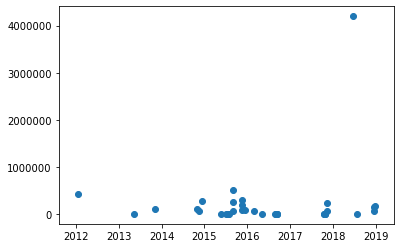

In [13]:
import matplotlib.pyplot as plt

outages_for_plotting = df.drop(columns=['Area Affected']).drop_duplicates()
outages_for_plotting['Event Date and Time'] = pd.to_datetime(outages_for_plotting['Event Date and Time'])
outages_for_plotting['no_cust_aff'] = outages_for_plotting['Number of Customers Affected'].map(lambda n: 0 if n == 'Unknown' else int(n))
ofp = outages_for_plotting[['Event Date and Time','no_cust_aff']]
plt.scatter(ofp['Event Date and Time'], ofp['no_cust_aff'])

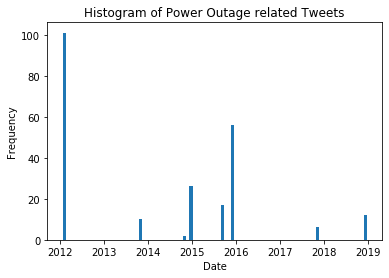

In [14]:
plt.hist(df_tweet_outage['timestamp'], bins = (12*8));
plt.gca().set(title='Histogram of Power Outage related Tweets', ylabel='Frequency', xlabel = 'Date');

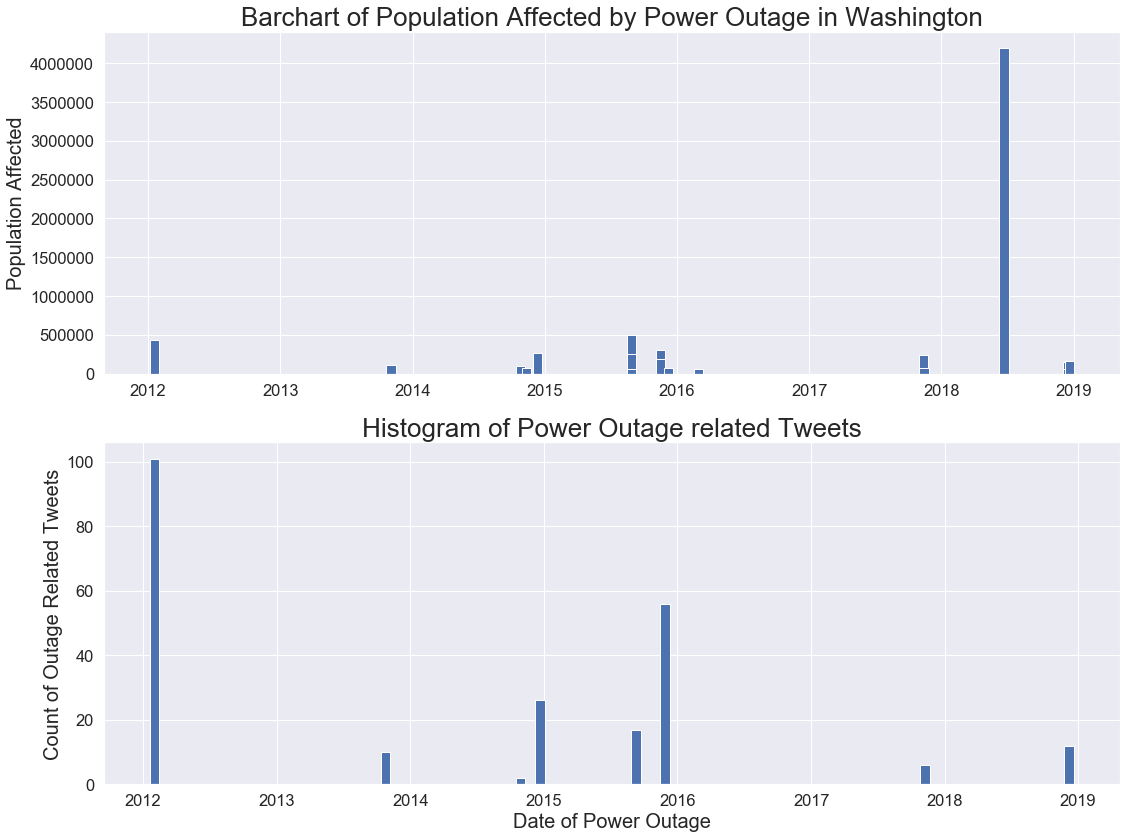

In [26]:
plt.figure(figsize = (16,12))

sns.set(font_scale = 1.5)

ax1 = plt.subplot(211)
ax1.set_title('Barchart of Population Affected by Power Outage in Washington', fontsize = 26)
ax1.set_ylabel('Population Affected', fontsize = 20)

ax1 = plt.bar(pd.to_datetime(ofp['Event Date and Time']), ofp['no_cust_aff'], width=26)

ax2 = plt.subplot(212)
ax2.set_title('Histogram of Power Outage related Tweets', fontsize = 26)
ax2.set_ylabel('Count of Outage Related Tweets', fontsize = 20)
ax2.set_xlabel('Date of Power Outage', fontsize = 20);
ax2 = plt.hist(df_tweet_outage['timestamp'], bins = (12*8));

plt.tight_layout()

plt.savefig('PowerOutageSubPlots.png')


In [27]:

stop_words = stopwords.words('english')

In [28]:
# Function to clean up tweets (removing urls, non-alphabetical characters)

def tweets_to_tweetlist(raw):
    clean = re.sub(r"[^a-zA-Z ]", "", raw)
    clean = re.sub(r"http.*?\b","",clean)
    clean = re.sub(r"pictwitter.*?\b","",clean)
    clean = re.sub(r"www.*?\b","",clean)
    return clean

In [29]:
# Iterate through all_tweets, clean tweets and add to tweet_list
all_tweets = df_tweet_outage['text']
tweet_list = []

for tweet in all_tweets:
    tweet_list.append(tweets_to_tweetlist(tweet))
len(tweet_list)

230

In [30]:
# Iterate through tweet_list convert to lowercase and tokenize each tweet

tokenized_tweet_list = [tweet.lower().split(' ') for tweet in tweet_list]

In [31]:
# final_tweet_list is the version of our tweet list we will use from here on

final_tweet_list = []

for tweet in tokenized_tweet_list:
    word_list = []
    for word in tweet:
        if (word not in stop_words) & (word != ''):
            word_list.append(word)
    final_tweet_list.append(word_list)

In [32]:

# Count number of words in tweets list (all tweets)

token_count = sum([len(tweet) for tweet in final_tweet_list])
print(f"The tweet list contains {token_count} tokens")

The tweet list contains 1904 tokens


In [33]:
final_tweet_list

[['numberforlife',
  'power',
  'issaquah',
  'highlands',
  'understand',
  'issaquah',
  'situation'],
 ['kingseattle',
  'kiroseattle',
  'tiger',
  'mountain',
  'rd',
  'se',
  'block',
  'way',
  'blocking',
  'trees',
  'power',
  'lines'],
 ['kingseattle',
  'kiroseattle',
  'se',
  'may',
  'valley',
  'road',
  'closed',
  'moment',
  'tree',
  'n',
  'power',
  'lines',
  'everywhere',
  'miles',
  'w',
  'isshobart',
  'rd'],
 ['lost', 'power', 'power', 'better', 'back'],
 ['update',
  'power',
  'outages',
  'affecting',
  'rentons',
  'benson',
  'neighborhood',
  'via'],
 ['still',
  'power',
  'reminds',
  'still',
  'love',
  'board',
  'games',
  'breaking',
  'monopoly',
  'battleship'],
 ['lilyjang', 'power', 'issaquah', 'hrs', 'help'],
 ['power', 'waterfuckinicestorms'],
 ['xbrandon', 'power', 'suckage', 'fully', 'started'],
 ['kingseattle',
  'thats',
  'good',
  'power',
  'days',
  'psetalk',
  'waice',
  'wapower'],
 ['power', 'outage', 'issaquah', 'highlands']

In [34]:
flattened_list = [y for x in final_tweet_list for y in x]

In [35]:
# final_tweet_df = pd.DataFrame(final_tweet_list) doesnt do anything

In [36]:
flattened_list

['numberforlife',
 'power',
 'issaquah',
 'highlands',
 'understand',
 'issaquah',
 'situation',
 'kingseattle',
 'kiroseattle',
 'tiger',
 'mountain',
 'rd',
 'se',
 'block',
 'way',
 'blocking',
 'trees',
 'power',
 'lines',
 'kingseattle',
 'kiroseattle',
 'se',
 'may',
 'valley',
 'road',
 'closed',
 'moment',
 'tree',
 'n',
 'power',
 'lines',
 'everywhere',
 'miles',
 'w',
 'isshobart',
 'rd',
 'lost',
 'power',
 'power',
 'better',
 'back',
 'update',
 'power',
 'outages',
 'affecting',
 'rentons',
 'benson',
 'neighborhood',
 'via',
 'still',
 'power',
 'reminds',
 'still',
 'love',
 'board',
 'games',
 'breaking',
 'monopoly',
 'battleship',
 'lilyjang',
 'power',
 'issaquah',
 'hrs',
 'help',
 'power',
 'waterfuckinicestorms',
 'xbrandon',
 'power',
 'suckage',
 'fully',
 'started',
 'kingseattle',
 'thats',
 'good',
 'power',
 'days',
 'psetalk',
 'waice',
 'wapower',
 'power',
 'outage',
 'issaquah',
 'highlands',
 'power',
 'went',
 'brucetennen',
 'lets',
 'use',
 'nat',


In [37]:
d = {x:flattened_list.count(x) for x in flattened_list}

In [38]:
#Creating dataframe by converting dict to list of items

list_common_words = pd.DataFrame(list(d.items()))

In [39]:
list_common_words.rename(columns={0:'Word',
                          1:'Count'}, 
                 inplace=True)

In [40]:
short_common_words = list_common_words.sort_values(by='Count', ascending = False).head(10)
short_common_words

,Word,Count
1,power,234
38,still,20
60,outage,19
37,via,15
30,back,12
91,night,12
57,psetalk,12
61,went,12
75,im,11
103,storm,11


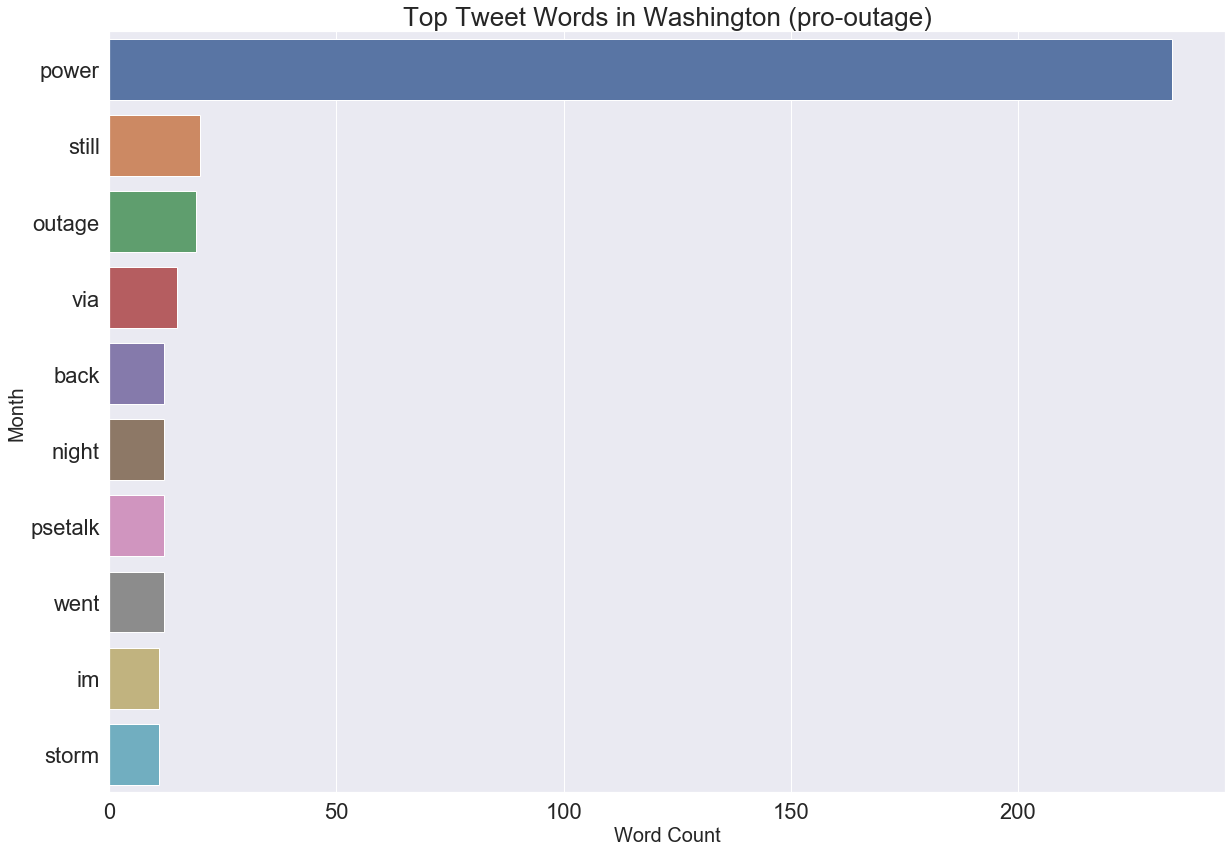

In [53]:
plt.figure(figsize = (20,14))

sns.set_style("whitegrid")
sns.set(font_scale = 2)
ax3 = sns.barplot(data=short_common_words.head(10),x='Count',y='Word',orient='h')
ax3.set_xlabel('Word Count', fontsize=20)
ax3.set_ylabel('Month', fontsize=20)
ax3.set_title('Top 10 Tweet Words in Washington (pro-outage)',fontsize = 26)

plt.savefig('TopTweetWords.png')

In [ ]:
def fibo (n):
    result = [1,1]
    i = 2
    if n < 3 :
        return 1
    else :
        while i <= n :
            result[i] = result[i-1] + result[i-2] 
            i += 1
        return result[n]

In [ ]:
fibo (3)